Please submit a PDF of your notebook with all the outputs, and separately the source code on Gradescope. You grade will be primarily based on the outputs in the PDF submission. Please refer to the introductory part of any previous problem set in this class regarding general homework standards and procedures. 

In [ ]:
#importing libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/mad_class/hw5/')

In [ ]:
!ls 

ConvModelCheckPoints	     LinearModelCheckPoints
ConvModelLearningCurve.png   LinearModelLearningCurve.png
ConvModel.png		     LinearModel.png
DataDistribution.png	     ReluDenseModelCheckPoints
DenseModelCheckPoints	     ReluDenseModelLearningCurve.png
DenseModelLearningCurve.png  ReluDenseModel.png
DenseModel.png		     sample_data
drive


In [ ]:
def plot_history(history, filename, model_name):
  best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
  fig, ax1 = plt.subplots(figsize=(12,8))
  plt.title(' '.join([model_name, 'model learning curve - Max accuracy on test is %1.4f' % max(history.history['val_accuracy'])]))
  ax1.set_xlabel('Epochs')
  ax1.set_xticks(range(Epochs))
  ax1.set_ylabel('Loss')
  ax1.plot(range(Epochs), history.history['loss'], 'r', label='Train Loss')
  ax1.plot(range(Epochs), history.history['val_loss'], 'orange', label='Test Loss')
  ax1.axvline(best_epoch, color='m', lw=4, alpha=0.5, label='Best epoch')
  ax1.legend()

  ax2 = ax1.twinx()
  ax2.set_ylabel('Accuracy')
  ax2.plot(range(Epochs), history.history['accuracy'], 'g', label='Train Accuracy')
  ax2.plot(range(Epochs), history.history['val_accuracy'], 'b', label='Test Accuracy')
  ax2.legend()

  plt.savefig(filename)
  plt.show()

def plot_first25labels(test_x, test_y, test_y_hat):
  #plotting first 25 samples with labels
  plt.figure(figsize=(12,12))
  plt.suptitle('First 25 samples of MNIST test dataset and their estimated labels\nActual lable -> Estimated label')
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title('%d -> %d' % (test_y[i], test_y_hat[i]))
    plt.imshow(test_x[i, :, :, 0], cmap='gray')
    plt.axis('off')

def plot_mislabeled(test_x, test_y, test_y_hat):
  #plotting first 25 samples with mislabeled
  rows = np.where(test_y_hat != test_y)[0]

  if len(rows) < 25:
    raise Exception('Mislabeled samples are less than 25 (%d). Perfect model!' % len(rows))

  plt.figure(figsize=(12,12))
  plt.suptitle('First 25 samples of MNIST test dataset that the model mislabeled\nActual lable -> Estimated label')
  for i in range(25):
    index = rows[i]
    plt.subplot(5,5,i+1)
    plt.title('%d -> %d' % (test_y[index], test_y_hat[index]))
    plt.imshow(test_x[index, :, :, 0], cmap='gray')
    plt.axis('off')

def plot_confusion(test_y, test_y_hat):
  # Show the confusion matrix
  cm = confusion_matrix(test_y, test_y_hat, normalize='true')

  df_cm = pd.DataFrame(cm, index = [i for i in range(10)],
                     columns = [i for i in range(10)])
  plt.figure(figsize = (10,7))  
  plt.title(' '.join(['Confusion matrix of', model_name]))  
  sn.heatmap(df_cm, annot=True, fmt='.2%')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()

In [ ]:
#loading data
mnist = tf.keras.datasets.mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

print('Shape of train_x is : %s (min= %1.2f, max= %1.2f)' % (str(train_x.shape), train_x.min(), train_x.max()))
print('Shape of train_y is : %s (min= %d, max= %d)' % (str(train_y.shape), train_y.min(), train_y.max()))

Shape of train_x is : (60000, 28, 28) (min= 0.00, max= 255.00)
Shape of train_y is : (60000,) (min= 0, max= 9)


In [ ]:
#preprocessing input
train_x = train_x.astype('float') / 255.0
test_x = test_x.astype('float') / 255.0

train_x = np.expand_dims(train_x, -1)
test_x = np.expand_dims(test_x, -1)

print('Shape of train_x is : %s (min= %1.2f, max= %1.2f)' % (str(train_x.shape), train_x.min(), train_x.max()))
print('Shape of train_y is : %s (min= %d, max= %d)' % (str(train_y.shape), train_y.min(), train_y.max()))

Shape of train_x is : (60000, 28, 28, 1) (min= 0.00, max= 1.00)
Shape of train_y is : (60000,) (min= 0, max= 9)


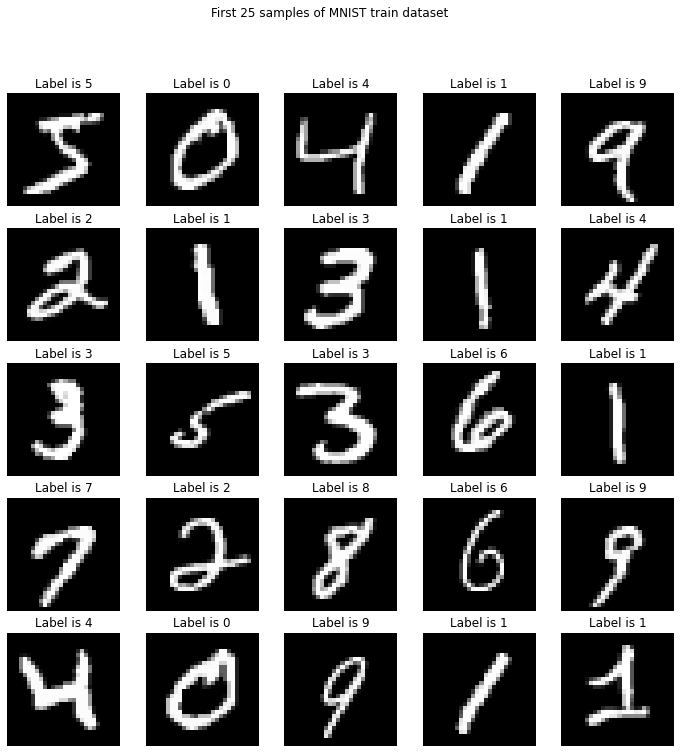

In [ ]:
#plotting first 25 samples
plt.figure(figsize=(12,12))
plt.suptitle('First 25 samples of MNIST train dataset')
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title('Label is %d' % train_y[i])
    plt.imshow(train_x[i, :, :, 0], cmap='gray')
    plt.axis('off')


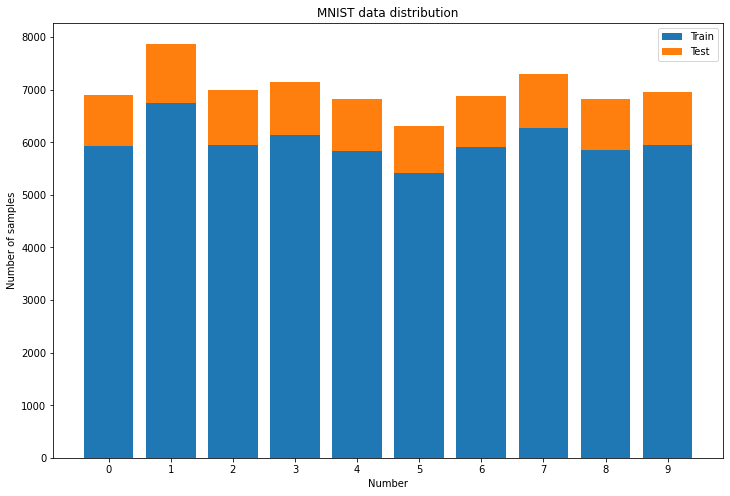

In [ ]:
#counting number of samples for each class and plotting them
(_, train_count) = np.unique(train_y, return_counts=True)
(_, test_count) = np.unique(test_y, return_counts=True)

plt.figure(figsize=(12,8))
plt.title('MNIST data distribution')
plt.xticks(range(10), labels=range(10))
plt.xlabel('Number')
plt.ylabel('Number of samples')
plt.bar(range(10), train_count, label='Train')
plt.bar(range(10), test_count, label='Test', bottom=train_count)
plt.legend()
plt.savefig('DataDistribution.png')
plt.show()

In [ ]:
Epochs = 10 #hyperparameter
BatchSize = 32 #hyperparameter

In [ ]:
#one hot encoding to match loss function expectation
one_hot_train_y = to_categorical(train_y, num_classes=10)
one_hot_test_y = to_categorical(test_y, num_classes=10)
print('Shape of one_hot_train_y is : ' + str(one_hot_train_y.shape))
print('Shape of one_hot_test_y is : ' + str(one_hot_test_y.shape))

Shape of one_hot_train_y is : (60000, 10)
Shape of one_hot_test_y is : (10000, 10)


(a) Using the model framework below in Question (b), define and train multinomial logistic regression, i.e., you will only have an input layer, a flattening layer, and an outer layer with softmax activation). You should get accuracy comparable to that of the model in Question (b) (~90%)

In [ ]:
!mkdir LinearModelCheckPoints

mkdir: cannot create directory ‘LinearModelCheckPoints’: File exists


In [ ]:
#training model
history = model.fit(train_x, one_hot_train_y, 
                    validation_data=(test_x, one_hot_test_y), 
                    epochs=Epochs, 
                    batch_size=BatchSize, 
                    callbacks=[
                        ModelCheckpoint(filepath='LinearModelCheckPoints/best_dense_model.h5', save_best_only=True), 
                        ModelCheckpoint(filepath='LinearModelCheckPoints/dense_model_{epoch:02d}.h5', save_best_only=False)])

In [ ]:
filename = 'LinearModelLearningCurve.png'
model_name = 'Multinomial Logistic Regression'
plot_history(history, filename, model_name)

In [ ]:
#loading best model (least validation loss)
model = load_model('LinearModelCheckPoints/best_dense_model.h5')
#evaluating model on test set
test_y_hat = model.predict(test_x)
print('test_y_hat shape is : ' + str(test_y_hat.shape))
#finding max and min of predictions
test_y_hat = np.argmax(test_y_hat, axis=1)
print('Now test_y_hat shape is : %s (min = %d, max = %d)' % (str(test_y_hat.shape), test_y_hat.min(), test_y_hat.max()))
plot_first25labels(test_x, test_y, test_y_hat)

In [ ]:
plot_mislabeled(test_x, test_y, test_y_hat)

In [ ]:
plot_confusion(test_y, test_y_hat)

In [ ]:
#printing classification report
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)]))

Question (b)

(i) Experiment with the  architecture of the following model to improve its accuracy (it can be increased to as high as ~95%). You can use the relu activation function in the internal layers and reduce the size of those layers. Please include the outputs of the original and modified models in your submission.

(ii) Can you try to explain why this improvement is achieved?

Model: "DenseModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 FlattenLayer (Flatten)      (None, 784)               0         
                                                                 
 DenseLayer1 (Dense)         (None, 128)               100480    
                                                                 
 DenseLayer2 (Dense)         (None, 64)                8256      
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


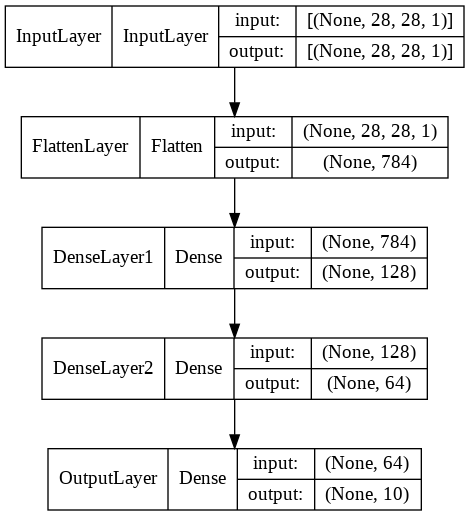

In [ ]:
inp = layers.Input(shape=(28,28,1), name='InputLayer')
x = layers.Flatten(name='FlattenLayer')(inp)
x = layers.Dense(128, activation='sigmoid' ,name='DenseLayer1')(x)
x = layers.Dense(64, activation='sigmoid' ,name='DenseLayer2')(x)
outp = layers.Dense(10, activation='softmax' ,name='OutputLayer')(x)

model = Model(inp, outp, name='DenseModel')
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.SGD(), metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True, to_file='DenseModel.png')

In [ ]:
!mkdir DenseModelCheckPoints

mkdir: cannot create directory ‘DenseModelCheckPoints’: File exists


In [ ]:
#training model
history = model.fit(train_x, one_hot_train_y, 
                    validation_data=(test_x, one_hot_test_y), 
                    epochs=Epochs, 
                    batch_size=BatchSize, 
                    callbacks=[
                        ModelCheckpoint(filepath='DenseModelCheckPoints/best_dense_model.h5', save_best_only=True), 
                        ModelCheckpoint(filepath='DenseModelCheckPoints/dense_model_{epoch:02d}.h5', save_best_only=False)])

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 2.1900 - accuracy: 0.3638 - val_loss: 2.0056 - val_accuracy: 0.6162
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.6612 - accuracy: 0.6398 - val_loss: 1.2847 - val_accuracy: 0.7345
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 1.0600 - accuracy: 0.7516 - val_loss: 0.8698 - val_accuracy: 0.7990
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7750 - accuracy: 0.8152 - val_loss: 0.6714 - val_accuracy: 0.8336
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6241 - accuracy: 0.8441 - val_loss: 0.5572 - val_accuracy: 0.8580
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5348 - accuracy: 0.8619 - val_loss: 0.4867 - val_accuracy: 0.8706
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4774 - accuracy: 0.8721 - val_loss: 0.4404 - val_accuracy:

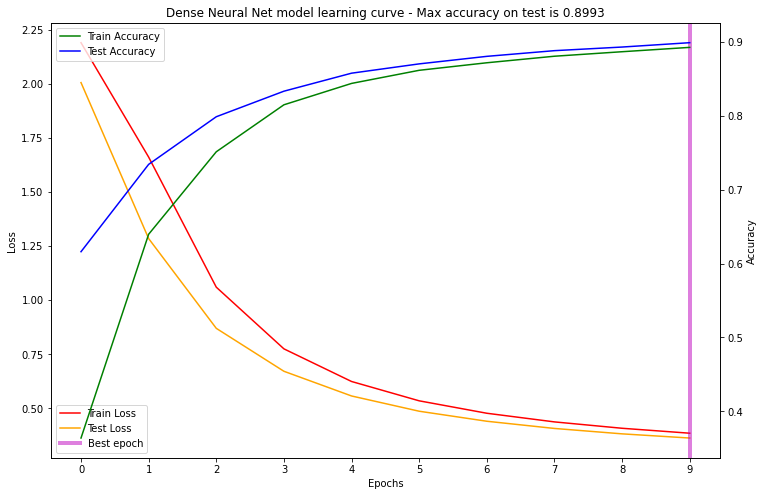

In [ ]:
#plotting learning curves and labelling them
filename='DenseModelLearningCurve.png'
model_name = 'Dense Neural Net' 
plot_history(history, filename, model_name)

In [ ]:
#loading best model (least validation loss)
model = load_model('DenseModelCheckPoints/best_dense_model.h5')

In [ ]:
#evaluating model on test set
test_y_hat = model.predict(test_x)
print('test_y_hat shape is : ' + str(test_y_hat.shape))

test_y_hat shape is : (10000, 10)


In [ ]:
#finding max and min of predictions
test_y_hat = np.argmax(test_y_hat, axis=1)
print('Now test_y_hat shape is : %s (min = %d, max = %d)' % (str(test_y_hat.shape), test_y_hat.min(), test_y_hat.max()))

Now test_y_hat shape is : (10000,) (min = 0, max = 9)


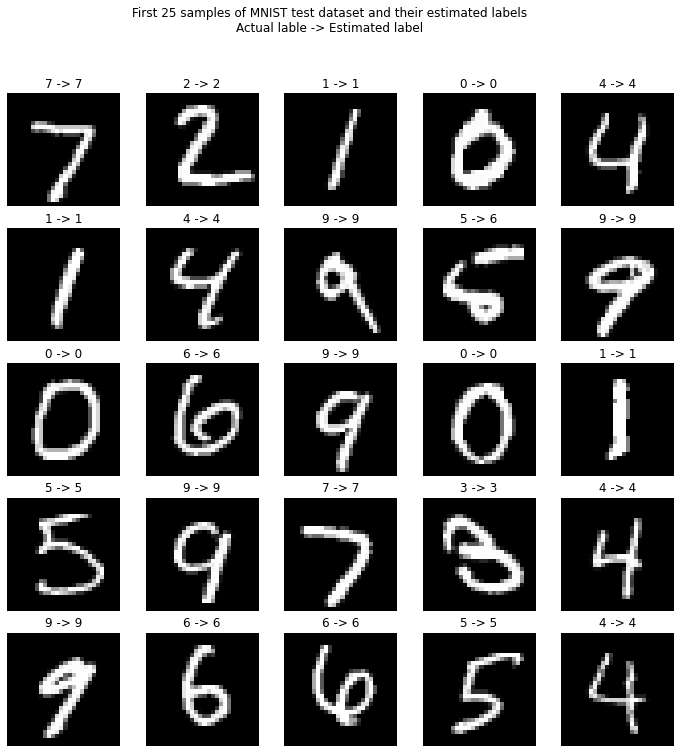

In [ ]:
#plotting first 25 samples with labels
plot_first25labels(test_x, test_y, test_y_hat)

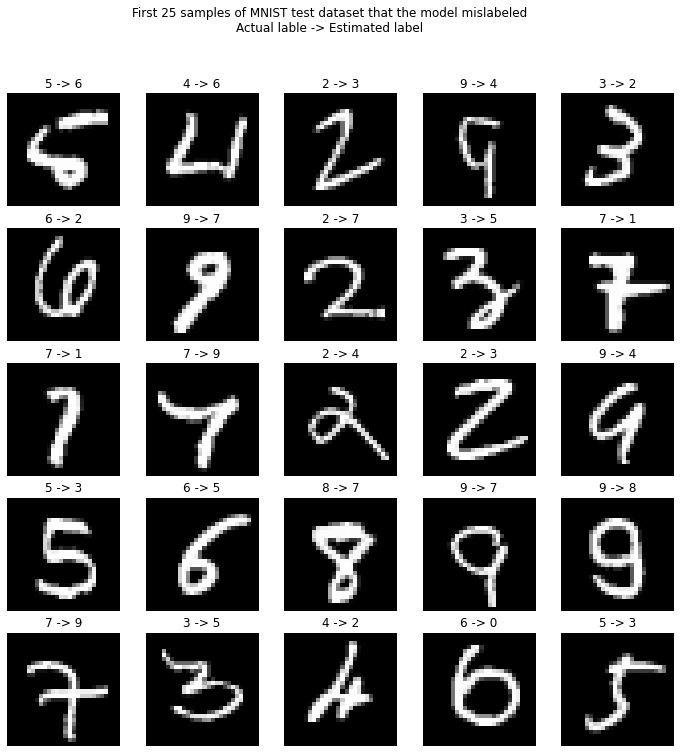

In [ ]:
plot_mislabeled(test_x, test_y, test_y_hat)

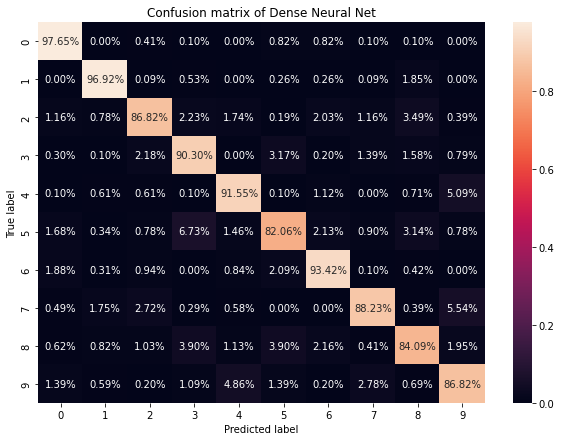

In [ ]:
# Show the confusion matrix
plot_confusion(test_y, test_y_hat)

In [ ]:
#printing classification report
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)]))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.95      0.97      0.96      1135
           2       0.91      0.87      0.89      1032
           3       0.86      0.90      0.88      1010
           4       0.90      0.92      0.91       982
           5       0.86      0.82      0.84       892
           6       0.91      0.93      0.92       958
           7       0.93      0.88      0.91      1028
           8       0.87      0.84      0.85       974
           9       0.86      0.87      0.86      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Question (c) 

Develop and train a CNN model for the above classification task. You can use the architecture below in the comments with Relu activation between internal layers and softmax in the output layer. You can get ~98% accuracy.  Use/review the keras documentation for, e.g., the following functions 

layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv1')(inp)

layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='MaxPooling1')(x) 
 

Model: "ConvModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 MaxPooling1 (MaxPooling2D)  (None, 13, 13, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 11, 11, 64)        18496     
                                                                 
 MaxPooling2 (MaxPooling2D)  (None, 3, 3, 64)          0         
                                                                 
 FlattenLayer (Flatten)      (None, 576)               0         
                                                                 
 DenseLayer1 (Dense)         (None, 128)               73

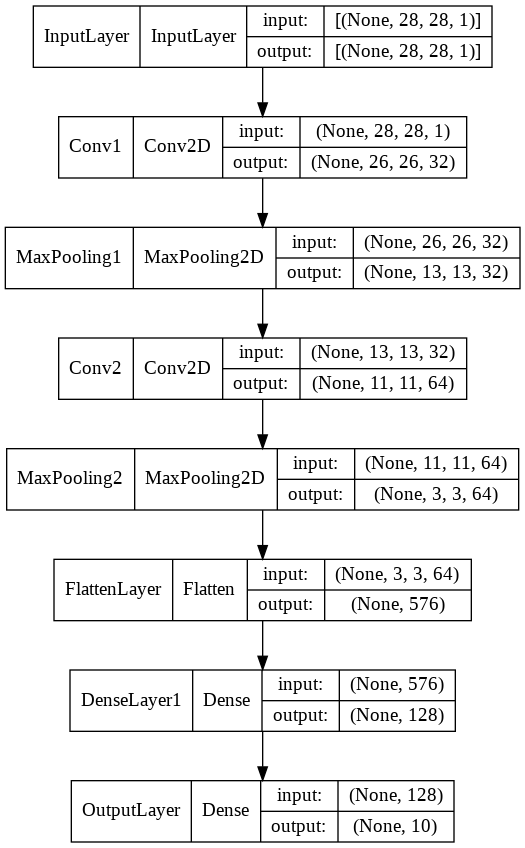

In [ ]:
#Model: "ConvModel"
#_________________________________________________________________
# Layer (type)                Output Shape              Param #   
#=================================================================
# InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
#                                                                 
# Conv1 (Conv2D)              (None, 26, 26, 32)        320     
#                             i.e., filters=32, kernel_size=(3,3)  
#                                                                 
# MaxPooling1 (MaxPooling2D)  (None, 13, 13, 32)        0         
#                              i.e., pool_size=(2,2), strides=(2,2)  
#                                 
# Conv2 (Conv2D)              (None, 11, 11, 64)        18496     
#                                                                 
# MaxPooling2 (MaxPooling2D)  (None, 3, 3, 64)          0         
#                              i.e., filters=64, kernel_size=(3,3)   
#                                
# FlattenLayer (Flatten)      (None, 576)               0         
#                                                                 
# DenseLayer1 (Dense)         (None, 128)               73856     
#                                                                 
# OutputLayer (Dense)         (None, 10)                1290   


In [ ]:
!mkdir ConvModelCheckPoints

mkdir: cannot create directory ‘ConvModelCheckPoints’: File exists


In [ ]:
#training the model
history = model.fit(train_x, one_hot_train_y, 
                    validation_data=(test_x, one_hot_test_y), 
                    epochs=Epochs, 
                    batch_size=BatchSize, 
                    callbacks=[
                        ModelCheckpoint(filepath='ConvModelCheckPoints/best_conv_model.h5', save_best_only=True), 
                        ModelCheckpoint(filepath='ConvModelCheckPoints/conv_model_{epoch:02d}.h5', save_best_only=False)])

In [ ]:
#plotting learning curves and labelling them
filename='ConvModelLearningCurve.png'
model_name = 'CNN' 
plot_history(history, filename, model_name)

In [ ]:
#loading best model
model = load_model('ConvModelCheckPoints/best_conv_model.h5')

In [ ]:
#finding shape of prediction
test_y_hat = model.predict(test_x)
print('test_y_hat shape is : ' + str(test_y_hat.shape))

In [ ]:
#finding minimum and maximum prediction values
test_y_hat = np.argmax(test_y_hat, axis=1)
print('Now test_y_hat shape is : %s (min = %d, max = %d)' % (str(test_y_hat.shape), test_y_hat.min(), test_y_hat.max()))

In [ ]:
#plotting first 25 samples 
plot_first25labels(test_x, test_y, test_y_hat)

In [ ]:
#plotting first 25 mislabeled images
plot_mislabeled(test_x, test_y, test_y_hat)

In [ ]:
#plotting confusion matrix
plot_confusion(test_y, test_y_hat)

In [ ]:
#plotting performance
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)]))